In [1]:
import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.gain.basic2 import Basic2

from psychrnn.backend.gain.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checkerPmdGain import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline



# configuration = tf.compat.v1.ConfigProto()
# configuration.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=configuration)

In [2]:
experiment = 'interactive'
name = 'basic'
dt = 10
tau = 50
T = 5000
N_batch = 50
N_rec = 100

g_bound = [0.1, 1]


# Generate a batch of trials with linear gain

In [3]:
task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch, g_bound = g_bound, noise = 0.25, accumulation_mask = 0)

In [4]:
params = task.get_task_params()
params

{'N_batch': 50,
 'N_in': 3,
 'N_out': 2,
 'dt': 10,
 'tau': 50,
 'T': 5000,
 'alpha': 0.2,
 'N_steps': 500,
 'coherence': [0, 1],
 'side': 0.5,
 'noise': 0.25,
 'target_onset': [250, 500],
 'checker_onset': [500, 1000],
 'accumulation_mask': 0,
 'decision_threshold': 0.7,
 'post_decision_baseline': 0.2,
 'wait': 0.2,
 'hi': 1,
 'lo': 0,
 'g_bound': [0.1, 1]}

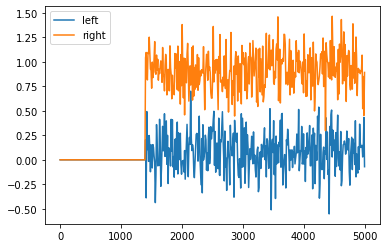

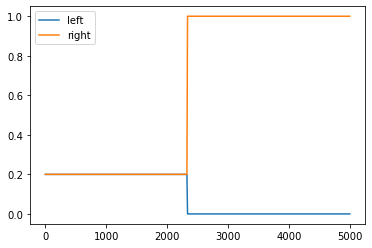

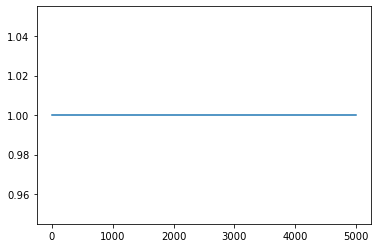

0.27765766595191693
931


In [5]:
#### must check RT and time step 

[x, y, mask, allParams, g, RT] = task.get_trial_batch()

trialNum = 2
# x[1]: left tartet evidence
# x[2]: right target evidence
trialIn = x[trialNum,:,0:2]
trialOut = y[trialNum,:,:]
trialMask = mask[trialNum,:,:]
time = np.linspace(0, task.T, int(task.T/task.dt))
# plot input to the model
plt.figure()
plt.plot(time, trialIn[:,0], label = 'left')
plt.plot(time, trialIn[:,1], label = 'right')
plt.legend()

# plot output to the model
plt.figure()
plt.plot(time, trialOut[:,0], label = 'left')
plt.plot(time, trialOut[:,1], label = 'right')
plt.legend()
# plot trial masks
plt.figure()
plt.plot(time, trialMask[:,0])

plt.show()
print(g[trialNum])
print(RT[trialNum])



# Set Network params

In [6]:
network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.5

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07


In [7]:
try:
    model.destruct()
except:
    pass

model = Basic2(network_params)
model.output_transfer_function = network_params.get(
    "output_transfer_function", tf.nn.relu
)
model.decision_threshold = network_params.get("decision_threshold", np.inf)

In [8]:
# check model
# vars(model)

# a = model.get_weights()
# a.keys()

In [9]:
# vars(model)

# Set Training params & Train

In [10]:
trials = 10000
train_params = {}
train_params['save_weights_path'] =  "./checkerPmdGainInput"
train_params['training_iters'] = trials
train_params['learning_rate'] = .001
train_params['loss_epoch'] = 10
train_params['save_training_weights_epoch'] = 1000 / N_batch
train_params['training_weights_path'] = None

In [11]:
losses, initialTime, trainTime = model.train(task, train_params)
loss_name = "./checkerPmdGainInput.txt"
print("Save losses to " + loss_name)
with open(loss_name, 'w') as f:
    for item in losses:
        f.write("%s\n" % item)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Iter 500, Minibatch Loss= 0.148905
Iter 1000, Minibatch Loss= 0.172629
Iter 1500, Minibatch Loss= 0.125171
Iter 2000, Minibatch Loss= 0.127835
Iter 2500, Minibatch Loss= 0.134321
Iter 3000, Minibatch Loss= 0.108546
Iter 3500, Minibatch Loss= 0.069091
Iter 4000, Minibatch Loss= 0.044345
Iter 4500, Minibatch Loss= 0.041855
Iter 5000, Minibatch Loss= 0.038475
Iter 5500, Minibatch Loss= 0.046558
Iter 6000, Minibatch Loss= 0.043210
Iter 6500, Minibatch Loss= 0.035109
Iter 7000, Minibatch Loss= 0.027071
Iter 7500, Minibatch Loss= 0.042992
Iter 8000, Minibatch Loss= 0.033695
Iter 8500, Minibatch Loss= 0.046602
Iter 9000, Minibatch Loss= 0.042755
Iter 9500, Minibatch Loss= 0.039299
Optimization finished!
Model saved in file: ./checkerPmdGainInput
Save losses to ./checkerPmdGainInput.txt


In [12]:
# weightsPath = "./weights/checkerPmdGain4Multiply.npz"
weightsPath = './weights/checkerPmdGain3Additive.npz'

weightsPath = './weights/checkerPmdGain3NoPreTrain.npz'

# weightsPath = './weights/checkerPmdGain4.npz'
# weightsPath = './weights/checkerPmdGain3A.npz'

# read saved weights
c = dict(np.load(weightsPath, allow_pickle = True))

c['W_rec'].shape

(100, 100)

In [13]:
init_state = c['init_state']
W_in = c['W_in']
W_out = c['W_out']
W_rec = c['W_rec']

In [ ]:
plt.imshow(W_rec, cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.show()

print(W_rec.shape)
print(np.sum(W_rec > 0))


In [ ]:
W_recP = W_rec[W_rec > 0]
print(np.sum(W_recP))
W_recN = W_rec[W_rec < 0]
print(np.sum(W_recN))

W_inP = W_in[W_in > 0]
print(np.sum(W_inP))
W_inN = W_in[W_in < 0]
print(np.sum(W_inN))

W_outP = W_out[W_out > 0]
print(np.sum(W_outP))
W_outN = W_out[W_out < 0]
print(np.sum(W_outN))

In [ ]:
sum1 = np.zeros((1000,1))
sum2 = np.zeros((1000,1))
for i in range(sum1.shape[0]):
    simu = np.random.uniform(0, 1, 100)
    simu2 =2*np.random.uniform(0, 1, 100)
#     simu = np.random.uniform(-1, 1, 100)
#     simu2 =2*np.random.uniform(-1, 1, 100)
    r1 = np.dot(W_rec, simu)
    r2 = np.dot(W_rec, simu2)
    sum1[i] = np.sum(r1)
    sum2[i] = np.sum(r2)
    
np.sum(sum2 > sum1)

# Test 5000 trials

In [14]:
trials =5000
batches = int(np.ceil(trials / N_batch))

rnn_state = np.zeros((trials, task.N_steps, model.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model.N_out))

coherence = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)
decision = np.zeros(trials)
rt = np.zeros(trials)
g0 = np.zeros(trials)
gSlope = np.zeros(trials)

In [15]:
params

{'N_batch': 50,
 'N_in': 3,
 'N_out': 2,
 'dt': 10,
 'tau': 50,
 'T': 5000,
 'alpha': 0.2,
 'N_steps': 500,
 'coherence': [0, 1],
 'side': 0.5,
 'noise': 0.25,
 'target_onset': [250, 500],
 'checker_onset': [500, 1000],
 'accumulation_mask': 0,
 'decision_threshold': 0.7,
 'post_decision_baseline': 0.2,
 'wait': 0.2,
 'hi': 1,
 'lo': 0,
 'g_bound': [0.1, 1],
 'name': 'basic',
 'N_rec': 100,
 'rec_noise': 0.5,
 'transfer_function': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>,
 'output_transfer_function': <function tensorflow.python.ops.math_ops.sigmoid(x, name=None)>,
 'loss_function': 'rt_mask_mse',
 'rt_mask_mse': <function psychrnn.backend.gain.loss.rt_mask_mse_07(predictions, y, output_mask)>}

In [16]:
for b in tqdm(range(batches)):
    [x, y, mask, params, g, RT] = task.get_trial_batch()
    outputs, states, inputs = model.test(x)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    
    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index] 
        g0[index] = g[i]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


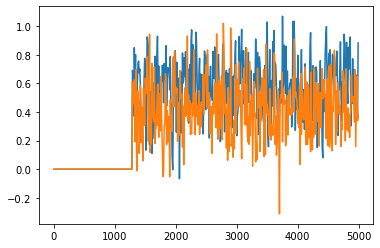

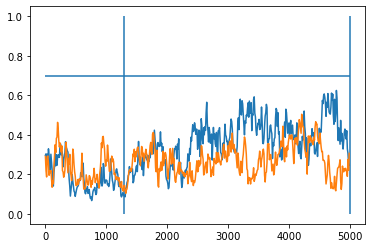

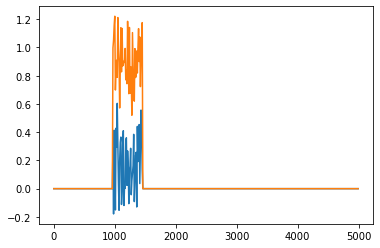

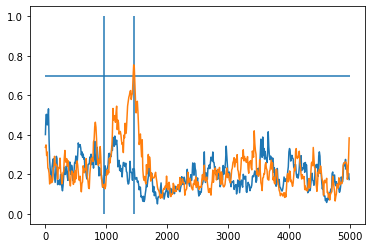

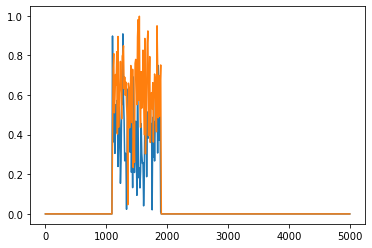

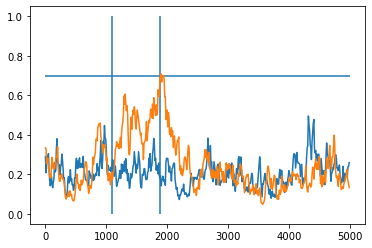

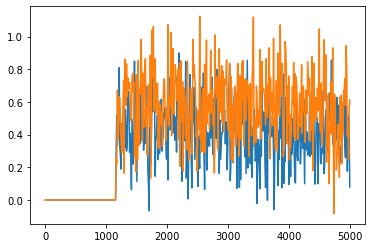

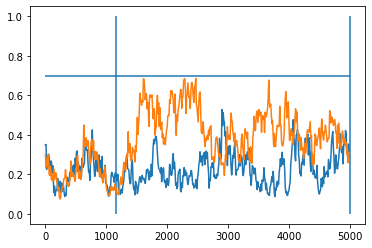

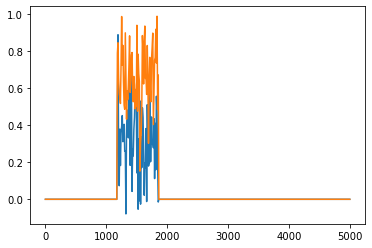

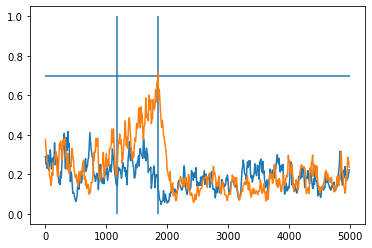

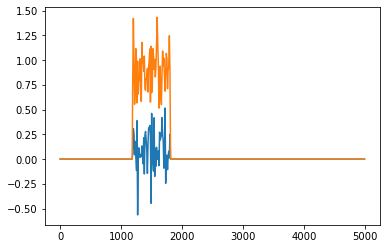

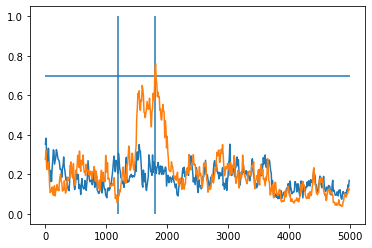

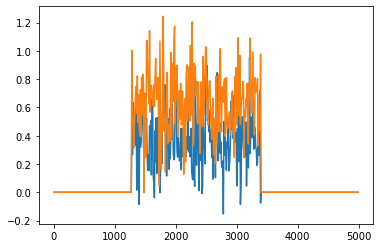

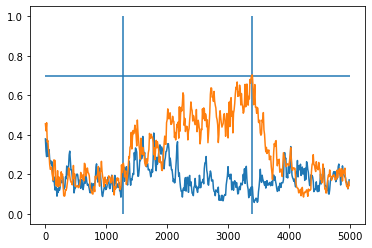

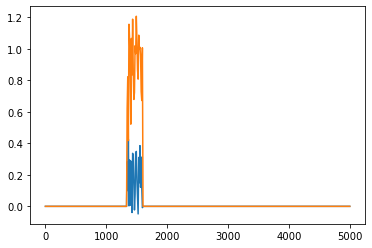

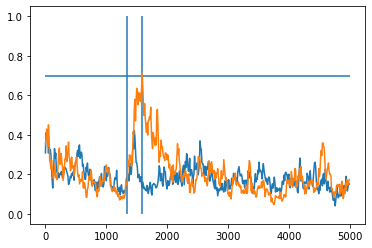

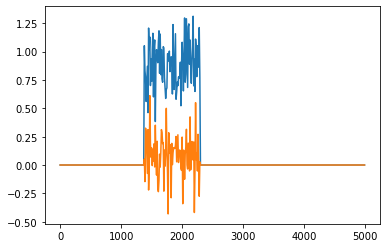

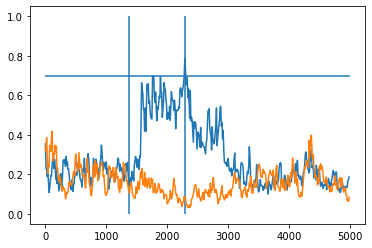

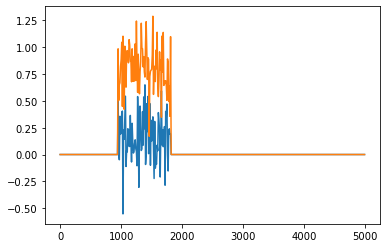

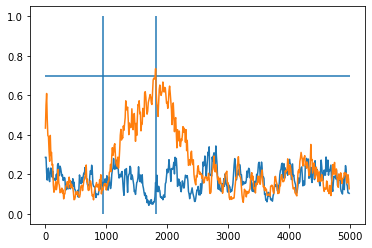

In [18]:
# plot example trials
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(0,10):
    plt.figure()
    plt.plot(np.arange(0, T, 10), inputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 1])

    plt.figure()
    plt.plot(np.arange(0, T, 10), outputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), outputs[i, :, 1])
    
    plt.vlines(onsets[i], 0, 1)
    plt.vlines(onsets[i] + rts[i], 0, 1)
    plt.hlines(0.7, 0, T)
#     plt.figure()
#     plt.plot(np.arange(0, T, 10), g[i])

In [19]:
correct_side = (coherence > 0.5)
correct_side = 1 - 1*correct_side

checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           # the real coherence based on left and right (positive: left evidence dominant
                           # negative: right evidence dominant)
                           'coherence' : 2*coherence - 1,
                           'coherence_bin' : np.round(2*coherence - 1, 1),
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int),
                          'g0' : g0})

checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()


print("Overall Accuracy: " + str(np.sum(checker_df["correct_decision"])/len(checker_df)))
print("Negative RT trials ratio: ", end = "")
print(np.sum(checker_df["decision_time"] < 0)/len(checker_df))



Overall Accuracy: 0.9472
Negative RT trials ratio: 0.0002


In [25]:
checker_df
#######################
## summary result save path

resultPath = "./gainInput.csv"
checker_df.to_csv(resultPath)

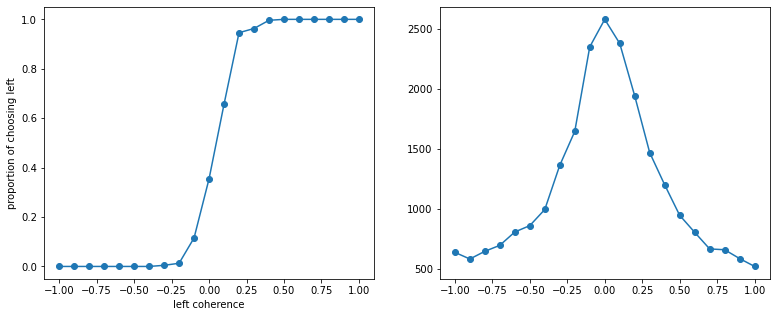

In [21]:
# psychrometric curve 
plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.plot(checker_mean['coherence_bin'], 1-checker_mean['decision'])
plt.scatter(checker_mean['coherence_bin'], 1-checker_mean['decision'])
plt.xlabel("left coherence")
plt.ylabel("proportion of choosing left")
plt.subplot(1,2,2)
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])



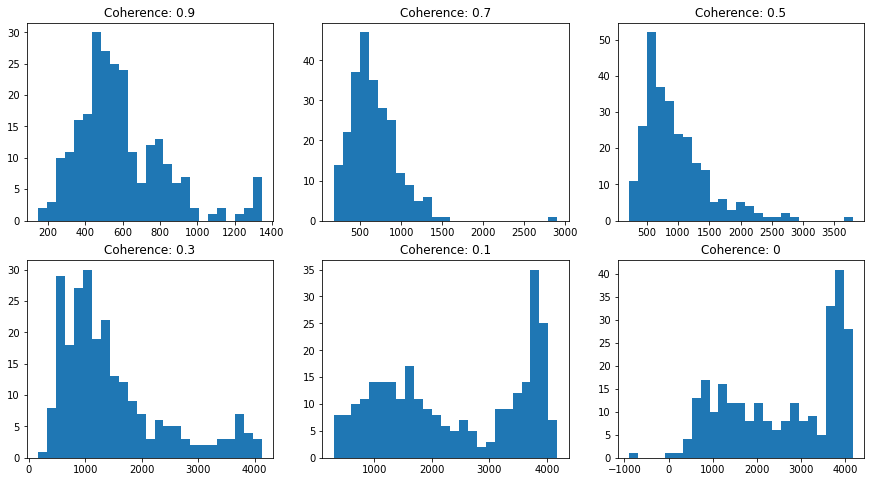

In [22]:
idx = 1
plt.figure(figsize=(15, 8))
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.subplot(2,3,idx)
    plt.hist(RT, bins = 25)
    plt.title("Coherence: " + str(i))
    idx = idx + 1

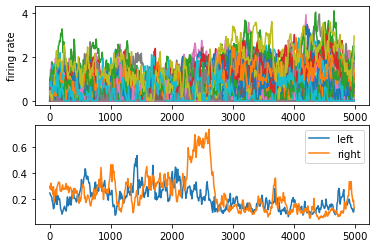

In [23]:
trial_num = 50
plt.figure()
plt.subplot(211)
_ = plt.plot(np.arange(0, T, dt), rnn_state[trial_num,:,:])
plt.xlabel("time step (10ms)")
plt.ylabel("firing rate")
plt.subplot(212)
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,0], label = "left")
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,1], label = "right")
plt.legend()

In [24]:
# transpose the data and save as .mat file for analysis on matlab
temp = np.transpose(rnn_state, (2,1,0))
from scipy.io import savemat
mdic = {'temp': temp}
savemat("temp.mat", mdic)

In [ ]:
model.destruct()